https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Use this regex to find and delete all In statements from pasted code
# In \[(.*)\]:

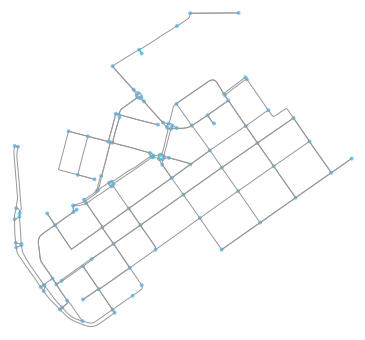

In [16]:
place_name = "Kamppi, Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)

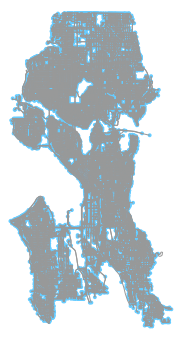

In [15]:
# this appears to be slow for larger graphs, may just be the plotting that is slow.
# place_name = "Seattle, Washington"
# graph = ox.graph_from_place(place_name, network_type='drive')
# fig, ax = ox.plot_graph(graph)

In [17]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [18]:
edges.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'name', 'highway',
       'maxspeed', 'length', 'geometry', 'junction', 'bridge', 'access'],
      dtype='object')

In [19]:
edges['highway'].value_counts()

residential      112
tertiary          78
primary           26
secondary         17
unclassified      11
living_street      4
primary_link       1
Name: highway, dtype: int64

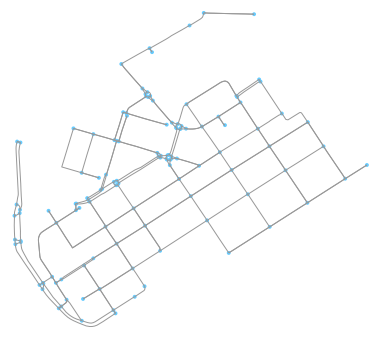

<Figure size 432x288 with 0 Axes>

In [20]:
graph_proj = ox.project_graph(graph)

fig, ax = ox.plot_graph(graph_proj)

plt.tight_layout()

In [21]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


In [22]:
edges_proj.head()

,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,junction,bridge,access
0,25216594,1372425714,0,23856784,True,2,Mechelininkatu,primary,40,40.885,LINESTRING (384631.3223718022 6671580.07062419...,NaN,NaN,NaN
1,25238874,1372425713,0,"[29977177, 30470347]",True,3,Mechelininkatu,primary,40,16.601,LINESTRING (384625.7872206579 6671454.38018930...,NaN,NaN,NaN
2,25238944,25216594,0,"[372440330, 8135861]",True,2,NaN,primary,40,25.190,LINESTRING (384643.4732736854 6671561.53381466...,NaN,NaN,NaN
3,25238944,319896278,0,"[25514547, 677423564, 30288797, 30288799]",True,"[3, 2]",Mechelininkatu,primary,40,242.476,LINESTRING (384643.4732736854 6671561.53381466...,NaN,NaN,NaN
4,25291537,25291591,0,"[30568275, 36729015, 316590744, 316590745, 316...",True,NaN,Fredrikinkatu,tertiary,"[30, 40]",139.090,LINESTRING (385515.5532442039 6671500.13400749...,NaN,NaN,NaN


To calculate some of the basic street network measures we can use basic_stats() function of osmnx

In [23]:
stats = ox.basic_stats(graph_proj)
stats

{'n': 124,
 'm': 249,
 'k_avg': 4.016129032258065,
 'intersection_count': 116,
 'streets_per_node_avg': 3.217741935483871,
 'streets_per_node_counts': {0: 0, 1: 8, 2: 1, 3: 71, 4: 44},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.06451612903225806,
  2: 0.008064516129032258,
  3: 0.5725806451612904,
  4: 0.3548387096774194},
 'edge_length_total': 19967.869000000006,
 'edge_length_avg': 80.1922449799197,
 'street_length_total': 13659.245000000003,
 'street_length_avg': 74.64068306010931,
 'street_segments_count': 183,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.2708230327883291e-05,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

To be able to extract the more advanced statistics (and some of the missing ones above) from the street network, it is required to have information about the coverage area of the network. Let’s calculate the area of the convex hull of the street network and see what we can get. As certain statistics are produced separately for each node, they produce a lot of output. Let’s merge both stats and put them into Pandas Series to keep things more compact.

In [10]:
# something wrong with Nx graph type
# area = edges_proj.unary_union.convex_hull.area
# stats = ox.basic_stats(graph_proj, area=area)
# extended_stats = ox.extended_stats(graph_proj, ecc=True, bc=True, cc=True)
# for key, value in extended_stats.items():
#     stats[key] = value

NetworkXNotImplemented: not implemented for multigraph type

## Shortest Path Analysis

In [11]:
edges_proj.bounds.head()

,minx,miny,maxx,maxy
0,384624.169953,6.671540e+06,384631.322372,6.671580e+06
1,384625.787221,6.671438e+06,384627.187049,6.671454e+06
2,384631.322372,6.671562e+06,384643.473274,6.671580e+06
3,384639.758183,6.671562e+06,384649.706785,6.671803e+06
4,385439.278556,6.671500e+06,385515.553244,6.671617e+06


In [12]:
from shapely.geometry import box
bbox = box(*edges_proj.unary_union.bounds)
print(bbox)

POLYGON ((385855.0300992894 6671142.734328128, 385855.0300992894 6672267.057001855, 384623.3898322977 6672267.057001855, 384623.3898322977 6671142.734328128, 385855.0300992894 6671142.734328128))


Okey so as a result we seem to have a Polygon, but what actually happened here? First of all, we took the Geometries from our edges_proj GeoDataFrame (123 features) and made a unary union of those features (as a result we have a MultiLineString). From the MultiLineString we can retrieve the maximum and minimum x and y coordinates of the geometry using the bounds attribute. The bounds command returns a tuple of four coordinates (minx, miny, maxx, maxy). As a final step we feed those coordinates into box() function that creates a shapely.Polygon object out of those coordinates. The * -character is used to unpack the values from the tuple (see details)

    Now we can extract the centroid of our bounding box as the source location.


In [13]:
orig_point = bbox.centroid
print(orig_point)

POINT (385239.2099657936 6671704.895664992)


Let’s now find the easternmost node in our street network. We can do this by calculating the x coordinates and finding out which node has the largest x-coordinate value. Let’s ensure that the values are floats.

In [25]:
nodes_proj['x'] = nodes_proj.x.astype(float)
maxx = nodes_proj['x'].max()

 Let’s retrieve the target Point having the largest x-coordinate. We can do this by using the .loc function of Pandas that we have used already many times in earlier tutorials.

In [27]:
target_loc = nodes_proj.loc[nodes_proj['x']==maxx, :]
print(target_loc)

                      y              x      osmid          highway        lon  \
317703609  6.671722e+06  385855.030099  317703609  traffic_signals  24.943012   

                lat                                     geometry  
317703609  60.16641  POINT (385855.0300992894 6671721.810323974)  


Okey now we can see that as a result we have a GeoDataFrame with only one node and the information associated with it.
Let’s extract the Point geometry from the data.


In [29]:
target_point = target_loc.geometry.values[0]
print(target_point)

POINT (385855.0300992894 6671721.810323974)



    Let’s now find the nearest graph nodes (and their node-ids) to these points. For osmnx we need to parse the coordinates of the Point as coordinate-tuple with Latitude, Longitude coordinates.

As our data is now projected to UTM projection, we need to specify with method parameter that the function uses ‘euclidean’ distances to calculate the distance from the point to the closest node. This becomes important if you want to know the actual distance between the Point and the closest node which you can retrieve by specifying parameter return_dist=True.

In [32]:
orig_xy = (orig_point.y, orig_point.x)

target_xy = (target_point.y, target_point.x)

orig_node = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')

target_node = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')

o_closest = nodes_proj.loc[orig_node]

t_closest = nodes_proj.loc[target_node]

print('orig_node: ',orig_node,'\n','target_node: ',target_node)

orig_node:  1372441189 
 target_node:  317703609


Let’s make a GeoDataFrame out of these series

In [34]:
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)

Okey, as a result we got now the closest node-ids of our origin and target locations.

    Now we are ready to do the routing and find the shortest path between the origin and target locations

by using the shortest_path() function of networkx. With weight -parameter we can specify that 'length' attribute should be used as the cost impedance in the routing.

In [38]:
shortest_len = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

print(shortest_len)

[1372441189, 1372441183, 1372441170, 60170471, 1377211668, 1377211666, 25291565, 25291564, 317703609]


In [39]:
shortest_time = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='max_speed')

print(shortest_time)

[1372441189, 1372441183, 1372441170, 60170471, 1377211668, 60170470, 1377211669, 25291564, 317703609]


Okey, as a result we get a list of all the nodes that are along the shortest path. We could extract the locations of those nodes from the nodes_proj GeoDataFrame and create a LineString presentation of the points, but luckily, osmnx can do that for us and we can plot shortest path by using plot_graph_route() function.

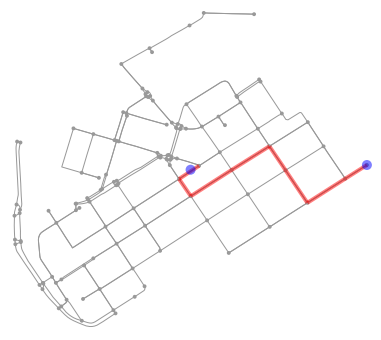

<Figure size 432x288 with 0 Axes>

In [41]:
fig, ax = ox.plot_graph_route(graph_proj, shortest_len, origin_point=orig_xy, destination_point=target_xy)
plt.tight_layout()

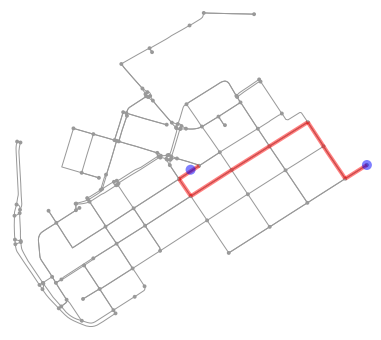

<Figure size 432x288 with 0 Axes>

In [42]:
fig, ax = ox.plot_graph_route(graph_proj, shortest_time, origin_point=orig_xy, destination_point=target_xy)
plt.tight_layout()

Awesome! Now we have a the shortest path between our origin and target locations. Being able to analyze shortest paths between locations can be valuable information for many applications. Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

## Saving Shortest path to disk

In [44]:
 route_nodes = nodes_proj.loc[shortest_len]

 print(route_nodes)

                       y              x       osmid          highway  \
1372441189  6.671719e+06  385268.933058  1372441189              NaN   
1372441183  6.671672e+06  385199.040423  1372441183              NaN   
1372441170  6.671610e+06  385239.956998  1372441170              NaN   
60170471    6.671704e+06  385382.616738    60170471              NaN   
1377211668  6.671789e+06  385514.573340  1377211668              NaN   
1377211666  6.671703e+06  385570.886277  1377211666              NaN   
25291565    6.671586e+06  385647.124210    25291565  traffic_signals   
25291564    6.671673e+06  385779.207015    25291564              NaN   
317703609   6.671722e+06  385855.030099   317703609  traffic_signals   

                  lon        lat                                     geometry  
1372441189  24.932459  60.166221  POINT (385268.9330583086 6671719.066545305)  
1372441183  24.931227  60.165777  POINT (385199.0404225526 6671671.819812791)  
1372441170  24.931999  60.165235  POINT

Now we can create a LineString out of the Point geometries of the nodes

In [45]:
 from shapely.geometry import LineString, Point

 route_line = LineString(list(route_nodes.geometry.values))

 print(route_line)

LINESTRING (385268.9330583086 6671719.066545305, 385199.0404225526 6671671.819812791, 385239.9569982953 6671610.080006042, 385382.6167378228 6671703.996054845, 385514.5733395503 6671789.024360122, 385570.8862774068 6671702.891685122, 385647.1242095508 6671586.215692636, 385779.2070153267 6671672.709376794, 385855.0300992894 6671721.810323974)


Let’s make a GeoDataFrame having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.

In [46]:
 route_geom = gpd.GeoDataFrame(crs=edges_proj.crs)

 route_geom['geometry'] = None

 route_geom['osmids'] = None

Let’s add the information: geometry, a list of osmids and the length of the route.

In [47]:
 route_geom.loc[0, 'geometry'] = route_line

 route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

 route_geom['length_m'] = route_geom.length

Now we have a GeoDataFrame that we can save to disk. Let’s still confirm that everything is okey by plotting our route on top of our street network, and plot also the origin and target points on top of our map.

    Let’s first prepare a GeoDataFrame for our origin and target points.


In [48]:
 od_points = gpd.GeoDataFrame(crs=edges_proj.crs)

 od_points['geometry'] = None

 od_points['type'] = None

 od_points.loc[0, ['geometry', 'type']] = orig_point, 'Origin'

 od_points.loc[1, ['geometry', 'type']] = target_point, 'Target'

 od_points.head()

,geometry,type
0,POINT (385239.2099657936 6671704.895664992),Origin
1,POINT (385855.0300992894 6671721.810323974),Target


Let’s also get the buildings for our area and plot them as well.

In [51]:
place_name

'Kamppi, Helsinki, Finland'

In [54]:
buildings = ox.footprints_from_place(place_name)
buildings_proj = buildings.to_crs(crs=edges_proj.crs)

Let’s now plot the route and the street network elements to verify that everything is as it should.

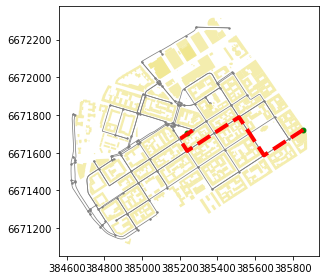

In [55]:
fig, ax = plt.subplots()
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')

nodes_proj.plot(ax=ax, markersize=2, color='gray')

buildings_proj.plot(ax=ax, facecolor='khaki', alpha=0.7)

route_geom.plot(ax=ax, linewidth=4, linestyle='--', color='red')

od_points.plot(ax=ax, markersize=24, color='green')

plt.tight_layout()

Great everything seems to be in order! As you can see, now we have a full control of all the elements of our map and we can use all the aesthetic properties that matplotlib provides to modify how our map will look like. Now we can save to disk all the elements that we want.

In [56]:
# Parse the place name for the output file names (replace spaces with underscores and remove commas)
place_name_out = place_name.replace(' ', '_').replace(',','')

streets_out = r"%s_streets.shp" % place_name_out

route_out = r"Route_from_a_to_b_at_%s.shp" % place_name_out

nodes_out = r"%s_nodes.shp" % place_name_out

buildings_out = r"%s_buildings.shp" % place_name_out

od_out = r"%s_route_OD_points.shp" % place_name_out

As there are certain columns with such data values that Shapefile format does not support (such as list or boolean), we need to convert those into strings to be able to export the data to Shapefile.

    Columns with invalid values

In [57]:
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid']

    Iterate over invalid columns and convert them to string format

In [58]:
for col in invalid_cols:
    edges_proj[col] = edges_proj[col].astype(str) 

    Save the data

In [59]:
edges_proj.to_file(streets_out)

route_geom.to_file(route_out)

nodes_proj.to_file(nodes_out)

od_points.to_file(od_out)

buildings[['geometry', 'name', 'addr:street']].to_file(buildings_out)

Great now we have saved all the data that was used to produce the maps as Shapefiles.